In [ ]:
!nvidia-smi


Sun Jun  5 19:49:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    30W /  70W |   2480MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras import backend as K

import torch.nn as nn

tf.keras.backend.set_floatx('float64')

class reuse_layer(Layer):
    def __init__(self,activation):
        super(reuse_layer, self).__init__()
        self.activation = activation
        self.no_of_neurons = 1024


    def build(self, input_shape_L):
        self.input_shape_L = input_shape_L
        self.kernel = self.add_weight("kernel",
                            shape=[int(input_shape_L[-1]),
                                    self.no_of_neurons])
        self.bias = self.add_weight("bais",
                            shape=[1,
                                    self.no_of_neurons])
        self.kernel_1 = self.add_weight("kernel_1",
                            shape=[self.no_of_neurons,
                                    self.no_of_neurons])
        self.bias_1 = self.add_weight("bais_1",
                            shape=[1,
                                    self.no_of_neurons])
        
        self.kernel_2 = self.add_weight("kernel_2",
                            shape=[self.no_of_neurons,
                                    self.no_of_neurons])
        self.bias_2 = self.add_weight("bais_2",
                            shape=[1,
                                    self.no_of_neurons])
        self.kernel_3 = self.add_weight("kernel_3",
                            shape=[self.no_of_neurons,
                                    self.no_of_neurons])
        self.bias_3 = self.add_weight("bais_3",
                            shape=[1,
                                    self.no_of_neurons])
                            
        self.output_kernel = self.add_weight("output_kernel",
                            shape=[self.no_of_neurons,
                                    1])
        self.ouput_bias = self.add_weight("bais",
                            shape=[1,
                                    1])
    def call(self, inputs):
        self.intermediate_output = []
        output = tf.matmul(inputs,self.kernel) + self.bias
        output = self.activation(output)

        output = tf.matmul(output,self.kernel_1) + self.bias_1
        output = self.activation(output)

        output = tf.matmul(output,self.kernel_2) + self.bias_2
        output = self.activation(output)

        output = tf.matmul(output,self.kernel_3) + self.bias_3
        output = self.activation(output)

        output = tf.matmul(output,self.output_kernel) + self.ouput_bias
        # self.intermediate_output = self.intermediate_output + [output.numpy()]
        # output = self.activation(output)
        for i in range(4):
            output = tf.matmul(output,self.kernel) + self.bias
            output = self.activation(output)

            output = tf.matmul(output,self.kernel_1) + self.bias_1
            output = self.activation(output)

            output = tf.matmul(output,self.kernel_2) + self.bias_2
            output = self.activation(output)

            output = tf.matmul(output,self.kernel_3) + self.bias_3
            output = self.activation(output)



            output = tf.matmul(output,self.output_kernel) + self.ouput_bias
            # self.intermediate_output = self.intermediate_output + [output.numpy()]
        # output = tf.matmul(output,self.kernel) + self.bias
        # output = self.activation(output)
        # output = tf.matmul(output,self.kernel) + self.bias
        # output = self.activation(output)

        return output


use_experimental_model = True
model = Sequential()
# model.add(Dense(1024,activation='tanh'))
# model.add(Dense(1024,activation='tanh'))
# model.add(Dense(1024,activation='tanh'))
# model.add(Dense(1024,activation='tanh'))


model.add(reuse_layer(tf.nn.tanh)) #0.02941868081688881 0.029556645080447197


    
    




  

  #one layer 0.05276414379477501
  #two layers 0.03996013477444649

# model.add(Dense(1,activation='linear'))
optimizer = Adam(0.001)#,clipvalue=0.1)#,clipnorm=1.0)
model.compile(loss='mse', optimizer=optimizer, run_eagerly=True)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def f(x):
    return x**(2**(1/5))#**3#(np.tanh(sigmoid(np.sin(x)+np.e**(x/5))+np.tanh(x))/2+1)**(x/5)

x = np.random.uniform(0,1.5,20000)
y = f(x)

x = np.expand_dims(x,-1)
y = np.expand_dims(y,-1)

test_size = 3000
val_size = 3000
x_test = x[-test_size:]
x_val = x[-test_size-val_size:-test_size]
x_train = x[:-test_size-val_size]

y_test = y[-test_size:]
y_val = y[-test_size-val_size:-test_size]
y_train = y[:-test_size-val_size]

def loss(x,y):
  return tf.reduce_mean(tf.square(tf.subtract(x,y)))

model.fit(x_train,y_train,batch_size=2048,epochs=20,validation_data=(x_val,y_val))
# K.set_value(model.optimizer.learning_rate, 0.0001)
# model.fit(x_train,y_train,batch_size=2048,epochs=1000,validation_data=(x_val,y_val))
# model.fit(x_train,y_train,batch_size=4096,epochs=500,validation_data=(x_val,y_val))
# K.set_value(model.optimizer.learning_rate, 0.000001)
# model.fit(x_train,y_train,batch_size=4096,epochs=100,validation_data=(x_val,y_val))
# model.summary()

# test_data = np.random.uniform(0,1.5,20000)#np.expand_dims(np.append(np.linspace(-17,-15,3000),np.linspace(15,17,3000)),-1)
# test_truth = f(test_data)
# plt.plot(test_data,model.predict(test_data),label='prediction')
# plt.plot(test_data,test_truth,label='truth')
# plt.legend()
# plt.show()
# print(model.evaluate(test_data,test_truth))

Epoch 1/20
7/7 [==============================] - 7s 985ms/step - loss: 37.8589 - val_loss: 7.2141
Epoch 2/20
7/7 [==============================] - 7s 984ms/step - loss: 1.6270 - val_loss: 0.2599
Epoch 3/20
7/7 [==============================] - 7s 989ms/step - loss: 0.2632 - val_loss: 0.3893
Epoch 4/20
7/7 [==============================] - 7s 995ms/step - loss: 0.3102 - val_loss: 0.2857
Epoch 5/20
7/7 [==============================] - 7s 1s/step - loss: 0.2715 - val_loss: 0.2206
Epoch 6/20
7/7 [==============================] - 7s 985ms/step - loss: 0.2482 - val_loss: 0.2171
Epoch 7/20
7/7 [==============================] - 7s 984ms/step - loss: 0.2292 - val_loss: 0.2160
Epoch 8/20
7/7 [==============================] - 7s 979ms/step - loss: 0.2242 - val_loss: 0.2152
Epoch 9/20
7/7 [==============================] - 7s 981ms/step - loss: 0.2218 - val_loss: 0.2139
Epoch 10/20
7/7 [==============================] - 7s 977ms/step - loss: 0.2203 - val_loss: 0.2128
Epoch 11/20
7/7 [====

KeyboardInterrupt: ignored

**get model gradient**

In [ ]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Iterate over the batches of a dataset.
for epoch in range(25):
      # Open a GradientTape.
  with tf.GradientTape() as tape:
      # Forward pass.
      logits = model(x_train)
      # Loss value for this batch.
      loss_value = loss(y_train, logits)

  # Get gradients of loss wrt the weights.
  gradients = tape.gradient(loss_value, model.trainable_weights)


  dist = 0
  for i in gradients:
    dist = dist + tf.reduce_sum(tf.square(i))
  dist = tf.sqrt(dist)

  for i in range(len(gradients)):
    gradients[i] = gradients[i]/dist


  # # Update the weights of the model.
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  print(epoch,loss_value,dist)



0 

KeyboardInterrupt: ignored

In [ ]:
gradients

[<tf.Tensor: shape=(1, 1024), dtype=float64, numpy=
 array([[ 0.00922598, -0.00229035,  0.00135314, ...,  0.00835771,
         -0.00526694,  0.00092288]])>,
 <tf.Tensor: shape=(1, 1024), dtype=float64, numpy=
 array([[ 0.01561771, -0.00388398,  0.00227503, ...,  0.01414348,
         -0.00892908,  0.00156212]])>,
 <tf.Tensor: shape=(1024, 1024), dtype=float64, numpy=
 array([[-5.03906731e-04,  1.24545814e-04, -2.18391108e-04, ...,
         -2.25615753e-04, -1.15810486e-04,  2.56406516e-04],
        [-2.74357211e-05,  6.80525314e-06, -1.18499156e-05, ...,
         -1.21074357e-05, -6.14132878e-06,  1.38021415e-05],
        [ 1.12871590e-03, -2.78918463e-04,  4.89273809e-04, ...,
          5.05767484e-04,  2.59783069e-04, -5.74694813e-04],
        ...,
        [-2.88656250e-05,  7.26970793e-06, -1.22835246e-05, ...,
         -1.19390245e-05, -5.71794439e-06,  1.38048382e-05],
        [-2.27681856e-04,  5.63571180e-05, -9.85369325e-05, ...,
         -1.01334980e-04, -5.17637147e-05,  1.153

In [ ]:
K.set_value(model.optimizer.learning_rate, 0.001)
model.fit(x_train,y_train,batch_size=2048,epochs=1000,validation_data=(x_val,y_val))

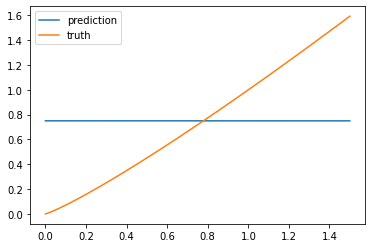

94/94 [==============================] - 2s 16ms/step - loss: 0.2203
0.22031100583693478


In [ ]:
test_data = np.linspace(0,1.5,3000)#np.expand_dims(np.append(np.linspace(-17,-15,3000),np.linspace(15,17,3000)),-1)
test_truth = f(test_data)
plt.plot(test_data,np.reshape(model.predict(test_data),-1),label='prediction')
plt.plot(test_data,test_truth,label='truth')
plt.legend()
plt.show()
print(model.evaluate(test_data,test_truth))

In [ ]:
model.predict([x_0])

array([[1.31071857]])

In [ ]:
x_0 = 1.2
for i in range(5):
    x_0 = model.predict([x_0])[0]
print(x_0)

[1.44425905]


In [ ]:
print(x,y)


[[ 0.22126772]
 [ 0.96620112]
 [-1.14108718]
 ...
 [ 1.08965492]
 [ 1.1992029 ]
 [ 1.42917647]] [[0.17681066]
 [0.9612738 ]
 [       nan]
 ...
 [1.10365616]
 [1.23203737]
 [1.50711665]]


In [ ]:
K.set_value(model.optimizer.learning_rate, 0.0001)
model.fit(x_train,y_train,batch_size=2048,epochs=1000,validation_data=(x_val,y_val))

Epoch 1/1000
2/2 [==============================] - 2s 1s/step - loss: 1.6055 - val_loss: 1.6389
Epoch 2/1000
2/2 [==============================] - 2s 2s/step - loss: 1.6055 - val_loss: 1.6389
Epoch 3/1000
2/2 [==============================] - 2s 1s/step - loss: 1.6055 - val_loss: 1.6389
Epoch 4/1000
2/2 [==============================] - 2s 1s/step - loss: 1.6055 - val_loss: 1.6389
Epoch 5/1000
2/2 [==============================] - 2s 1s/step - loss: 1.6055 - val_loss: 1.6389
Epoch 6/1000
2/2 [==============================] - 2s 1s/step - loss: 1.6055 - val_loss: 1.6389
Epoch 7/1000
2/2 [==============================] - 2s 1s/step - loss: 1.6055 - val_loss: 1.6389
Epoch 8/1000
2/2 [==============================] - 2s 1s/step - loss: 1.6055 - val_loss: 1.6389
Epoch 9/1000
1/2 [==============>...............] - ETA: 0s - loss: 1.5585

KeyboardInterrupt: ignored

In [ ]:
model.summary(
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reuse_layer (reuse_layer)   multiple                  8398849   
                                                                 
Total params: 8,398,849
Trainable params: 8,398,849
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train.shape

(2000, 1)

In [ ]:
s = model.predict(np.array([[.5]]))
params_1 = model.get_layer('reuse_layer').intermediate_output
params_1

ListWrapper([array([[-0.513133]], dtype=float32), array([[0.4998114]], dtype=float32), array([[-0.512945]], dtype=float32), array([[0.49962324]], dtype=float32), array([[-0.51275736]], dtype=float32), array([[0.4994354]], dtype=float32), array([[-0.5125702]], dtype=float32), array([[0.4992481]], dtype=float32), array([[-0.5123835]], dtype=float32), array([[0.49906123]], dtype=float32)])

In [ ]:
params_1

ListWrapper([array([[-0.9900663]], dtype=float32), array([[0.9817283]], dtype=float32)])